<a href="https://colab.research.google.com/github/celinamadaschi/Time-series-/blob/main/TimeSeries1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import read_csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis


FUNCTIONS

In [ ]:
# Define a function to convert 'YYYYQX' to a datetime object
def convert_quarter_to_date(quarter_str):
    year = int(quarter_str[:4])
    quarter = int(quarter_str[5])
    # Map quarter to a month (start of the quarter)
    month = (quarter - 1) * 3 + 1
    return pd.Timestamp(year=year, month=month, day=1)


In [ ]:
def changequarter(inputdata):

  dates = inputdata['QUARTER']

  for i in range(inputdata.shape[0]):
    if dates[i][5] == "1":
      new = dates[i].replace('Q1', '0101')
      inputdata['QUARTER'][i] = new
    elif dates[i][5] == "2":
      new = dates[i].replace('Q2', '0401')
      inputdata['QUARTER'][i] = new
    elif dates[i][5] == "3":
      new = dates[i].replace('Q3', '0701')
      inputdata['QUARTER'][i] = new
    elif dates[i][5] == "4":
      new = dates[i].replace('Q4', '1001')
      inputdata['QUARTER'][i] = new

  return inputdata

PREPARING DATAFRAMES

In [ ]:
# dataframe for regressions
inputregression = pd.read_excel('/content/IMPORTS.xlsx')
inputregression = inputregression.reset_index().rename(columns={'index': 'Index'})
inputregression['QUARTER'] = inputregression['QUARTER'].apply(convert_quarter_to_date)
inputregression.index = pd.to_datetime(inputregression['QUARTER'], format = '%Y-%m-%d')
inputregression['month'] = inputregression['QUARTER'].dt.month
tolag = inputregression['IMPORTS'].copy()
inputregression['laggedImports'] = tolag.shift(periods=1)
tolag2 = inputregression['IMPORTSSA'].copy()
inputregression['laggedImportssa'] = tolag2.shift(periods=1)
inputregression['IMPORTSSA_log'] = np.log(inputregression['IMPORTSSA'])
tolag3 = inputregression['IMPORTSSA_log'].copy()
inputregression['laggedIMPORTSSA_log'] = tolag3.shift(periods=1)
inputregression['logIMPORTSSA_diff'] = inputregression['IMPORTSSA_log'] - inputregression['laggedIMPORTSSA_log']
inputregression['logIMPORTSSA_diff_%'] = inputregression['logIMPORTSSA_diff'] * 100 / inputregression['laggedIMPORTSSA_log']
inputregression['D1'] = (inputregression['month'] == 1).astype(int)
inputregression['D2'] = (inputregression['month'] == 4).astype(int)
inputregression['D3'] = (inputregression['month'] == 7).astype(int)
inputregression['D4'] = (inputregression['month'] == 10).astype(int)
inputregression['diff'] = inputregression['IMPORTS'] - inputregression['laggedImports']
tolag4 = inputregression['IMPORTS'].copy()
inputregression['4lagIMPORTS'] = tolag2.shift(periods=4)
inputregression['seasonLag'] = inputregression['IMPORTS'] - inputregression['4lagIMPORTS']

# querterly dataframes
# creating dataframes for each season
q1df = inputregression[inputregression["D1"]==1]
q2df = inputregression[inputregression["D2"]==1]
q3df = inputregression[inputregression["D3"]==1]
q4df = inputregression[inputregression["D4"]==1]

q1df['diff'] = q1df['IMPORTS'].diff()
q2df['diff'] = q2df['IMPORTS'].diff()
q3df['diff'] = q3df['IMPORTS'].diff()
q4df['diff'] = q4df['IMPORTS'].diff()

# Make sure starts from 1980
inputregression = inputregression.iloc[4:]
q1df = q1df.iloc[1:]
q2df = q2df.iloc[1:]
q3df = q3df.iloc[1:]
q4df = q4df.iloc[1:]
# Reset Index column to start at 0
inputregression['Index'] = inputregression['Index'] - 4
inputregression

<ipython-input-124-081eee6d4d79>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1df['diff'] = q1df['IMPORTS'].diff()
<ipython-input-124-081eee6d4d79>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q2df['diff'] = q2df['IMPORTS'].diff()
<ipython-input-124-081eee6d4d79>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

,Index,QUARTER,IMPORTS,IMPORTSSA,DREC,month,laggedImports,laggedImportssa,IMPORTSSA_log,laggedIMPORTSSA_log,logIMPORTSSA_diff,logIMPORTSSA_diff_%,D1,D2,D3,D4,diff,4lagIMPORTS,seasonLag
QUARTER,,,,,,,,,,,,,,,,,,,
1980-01-01,0,1980-01-01,297.408,304.311,0,1,278.216,280.466,5.718050,5.636453,0.081598,1.447678,1,0,0,0,19.192,229.828,67.580
1980-04-01,1,1980-04-01,296.924,292.600,1,4,297.408,304.311,5.678806,5.718050,-0.039244,-0.686313,0,1,0,0,-0.484,243.097,53.827
1980-07-01,2,1980-07-01,284.556,279.202,1,7,296.924,292.600,5.631936,5.678806,-0.046871,-0.825366,0,0,1,0,-12.368,257.306,27.250
1980-10-01,3,1980-10-01,296.420,299.200,0,10,284.556,279.202,5.701112,5.631936,0.069177,1.228294,0,0,0,1,11.864,280.466,15.954
1981-01-01,4,1981-01-01,311.764,319.726,0,1,296.420,299.200,5.767464,5.701112,0.066352,1.163845,1,0,0,0,15.344,304.311,7.453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,171,2022-10-01,3909.276,3891.004,0,10,4085.820,3976.524,8.266423,8.288163,-0.021741,-0.262312,0,0,0,1,-176.544,3677.415,231.861
2023-01-01,172,2023-01-01,3692.388,3890.491,0,1,3909.276,3891.004,8.266291,8.266423,-0.000132,-0.001595,1,0,0,0,-216.888,3927.291,-234.903
2023-04-01,173,2023-04-01,3804.640,3767.851,0,4,3692.388,3890.491,8.234260,8.266291,-0.032031,-0.387484,0,1,0,0,112.252,4069.839,-265.199


**A)**
Trends


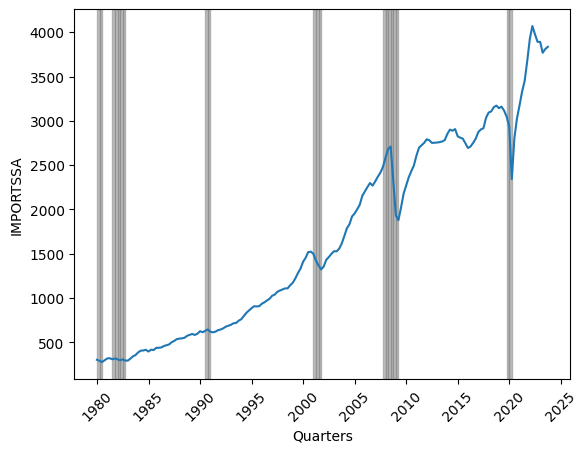

In [ ]:
plt.ylabel('IMPORTSSA')
plt.xlabel('Quarters')
plt.xticks(rotation = 45)

day = inputregression['QUARTER'][0]
for index, row in inputregression.iterrows():
    if row['DREC'] == 1:
        plt.axvspan(day, row['QUARTER'] , color='gray', alpha=0.5, )
    day = row['QUARTER']

plt.plot(inputregression.index, inputregression['IMPORTSSA'])

<Axes: xlabel='QUARTER'>

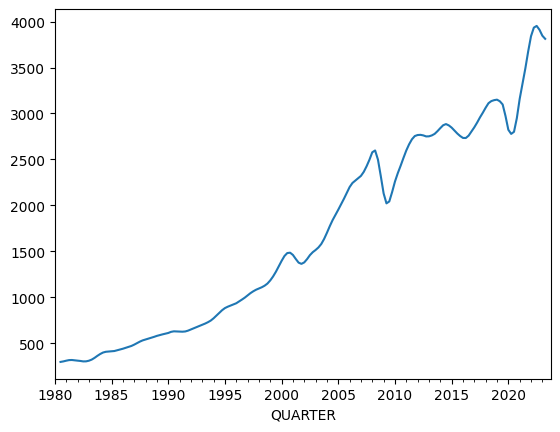

In [ ]:
# creating trend object by assuming multiplicative model
output = seasonal_decompose(inputregression['IMPORTS'], model='aditive').trend # if we change aditive for multiplicative, it is the same graph
# creating plot
output.plot()

In [ ]:
# pooled ols
formula = "IMPORTS ~ Index"
data = inputregression

model = sm.OLS.from_formula(formula, data).fit(disp=0)
print(model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.950    
Dependent Variable: IMPORTS          AIC:                2439.6995
Date:               2024-05-22 10:51 BIC:                2446.0405
No. Observations:   176              Log-Likelihood:     -1217.8  
Df Model:           1                F-statistic:        3311.    
Df Residuals:       174              Prob (F-statistic): 3.58e-115
R-squared:          0.950            Scale:              60643.   
------------------------------------------------------------------
                Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
------------------------------------------------------------------
Intercept     -157.2170  36.9670 -4.2529 0.0000 -230.1785 -84.2555
Index           21.0216   0.3654 57.5371 0.0000   20.3005  21.7427
------------------------------------------------------------------
Omnibus:               1.152        Durbin-Watson:           0.248
Prob(Omnibus)

SEASONALITY

<ipython-input-112-0ecf24e88e57>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1df['diff'] = q1df['diff'] * 100
<ipython-input-112-0ecf24e88e57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q2df['diff'] = q2df['diff'] * 100
<ipython-input-112-0ecf24e88e57>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

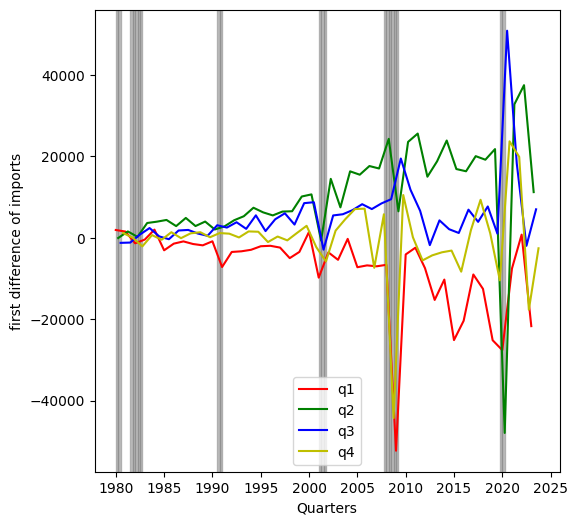

In [ ]:
q1df['diff'] = q1df['diff'] * 100
q2df['diff'] = q2df['diff'] * 100
q3df['diff'] = q3df['diff'] * 100
q4df['diff'] = q4df['diff'] * 100

fig, ax = plt.subplots(figsize=(6,6))

ax.plot(q1df.index, q1df['diff'], color='r', label='q1')
ax.plot(q2df.index, q2df['diff'], color='g', label='q2')
ax.plot(q3df.index, q3df['diff'], color='b', label='q3')
ax.plot(q4df.index, q4df['diff'], color='y', label='q4')

ax.set_xlabel('Quarters')
ax.set_ylabel('first difference of imports')

day = inputregression['QUARTER'][0]
for index, row in inputregression.iterrows():
    if row['DREC'] == 1:
        ax.axvspan(day, row['QUARTER'] , color='gray', alpha=0.5, )
    day = row['QUARTER']
ax.legend()

plt.show()

In [ ]:
inputregression['diff'] = inputregression['diff'] * 100

formula = "diff ~ D1 + D2 + D3 + D4 -1"
data = inputregression

model = sm.OLS.from_formula(formula, data).fit(disp=0)
print(model.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.277     
Dependent Variable: diff             AIC:                3759.0531 
Date:               2024-05-22 12:20 BIC:                3771.7350 
No. Observations:   176              Log-Likelihood:     -1875.5   
Df Model:           3                F-statistic:        23.32     
Df Residuals:       172              Prob (F-statistic): 1.02e-12  
R-squared:          0.289            Scale:              1.0803e+08
--------------------------------------------------------------------
       Coef.      Std.Err.     t     P>|t|      [0.025      0.975]  
--------------------------------------------------------------------
D1   -7336.7545  1566.9122  -4.6823  0.0000  -10429.6076  -4243.9015
D2   10206.0545  1566.9122   6.5135  0.0000    7113.2015  13298.9076
D3    5496.1182  1566.9122   3.5076  0.0006    2403.2651   8588.9713
D4    -250.1273  1566.9122  -0.1596  0.8734   -3342.9804   2

ABERRANT OBSERVATIONS

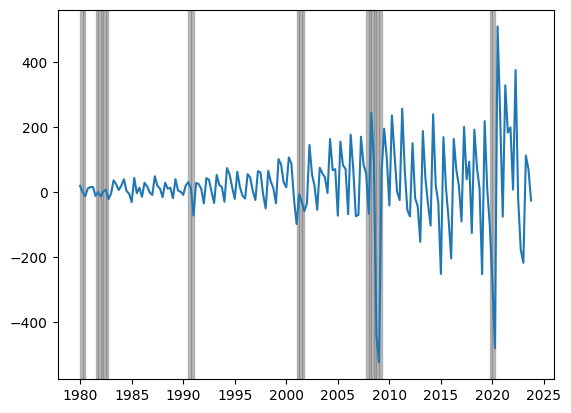

In [ ]:
day = inputregression['QUARTER'][0]
for index, row in inputregression.iterrows():
    if row['DREC'] == 1:
        plt.axvspan(day, row['QUARTER'] , color='gray', alpha=0.5, )
    day = row['QUARTER']
plt.plot(inputregression["QUARTER"], inputregression['diff'])

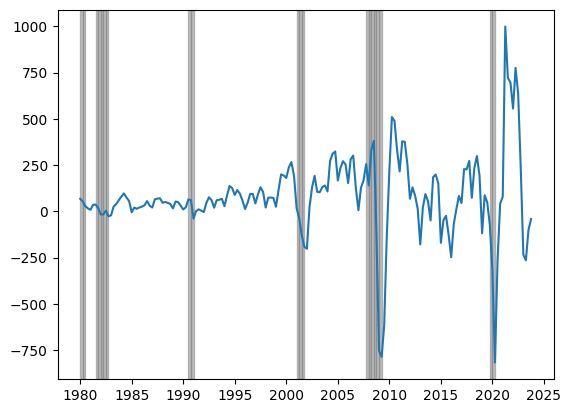

In [ ]:
day = inputregression['QUARTER'][0]
for index, row in inputregression.iterrows():
    if row['DREC'] == 1:
        plt.axvspan(day, row['QUARTER'] , color='gray', alpha=0.5, )
    day = row['QUARTER']
plt.plot(inputregression.index, inputregression['seasonLag'])

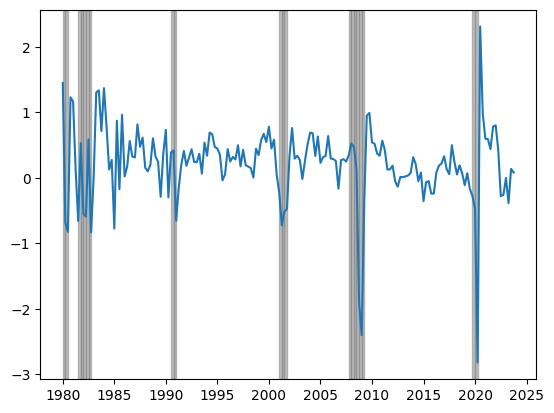

In [ ]:
day = inputregression['QUARTER'][0]
for index, row in inputregression.iterrows():
    if row['DREC'] == 1:
        plt.axvspan(day, row['QUARTER'] , color='gray', alpha=0.5, )
    day = row['QUARTER']
plt.plot(inputregression.index, inputregression['logIMPORTSSA_diff_%'])


HETEROSKEDASTICITY

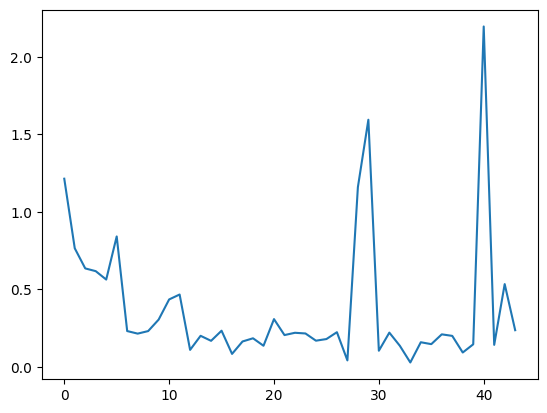

In [ ]:
inputregression['Year'] = inputregression['QUARTER'].dt.year

# Group data by year and calculate standard deviation for each group
std_per_year = inputregression.groupby('Year').std()

# Get the standard deviations as a vector (numpy array or pandas Series)
std_vector = std_per_year['logIMPORTSSA_diff_%']  # Assuming 'Value' is the column you want standard deviations for

# If you want to convert the result to a list, you can use .tolist() method
std_list = std_vector.tolist()
indexes = [i for i in range(0, len(std_list))]


plt.plot(indexes, std_list)



Regressions

In [ ]:
formula = "IMPORTS ~ Index"
data = inputregression

model = sm.OLS.from_formula(formula, data).fit(disp=0)
print(model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.950    
Dependent Variable: IMPORTS          AIC:                2439.6995
Date:               2024-05-22 10:53 BIC:                2446.0405
No. Observations:   176              Log-Likelihood:     -1217.8  
Df Model:           1                F-statistic:        3311.    
Df Residuals:       174              Prob (F-statistic): 3.58e-115
R-squared:          0.950            Scale:              60643.   
------------------------------------------------------------------
                Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
------------------------------------------------------------------
Intercept     -157.2170  36.9670 -4.2529 0.0000 -230.1785 -84.2555
Index           21.0216   0.3654 57.5371 0.0000   20.3005  21.7427
------------------------------------------------------------------
Omnibus:               1.152        Durbin-Watson:           0.248
Prob(Omnibus)

In [ ]:
formula = "IMPORTS - laggedImports ~ D1 + D2 + D3 + D4 -1"
data = inputregression

model = sm.OLS.from_formula(formula, data).fit(disp=0)
print(model.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.014    
Dependent Variable: IMPORTS          AIC:                2970.5825 
Date:               2024-05-22 10:58 BIC:                2983.2645 
No. Observations:   176              Log-Likelihood:     -1481.3   
Df Model:           3                F-statistic:        0.1938    
Df Residuals:       172              Prob (F-statistic): 0.900     
R-squared:          0.003            Scale:              1.2244e+06
---------------------------------------------------------------------
        Coef.     Std.Err.      t      P>|t|      [0.025      0.975] 
---------------------------------------------------------------------
D1    1578.7707   166.8156    9.4642   0.0000   1249.5014   1908.0401
D2    1680.8313   166.8156   10.0760   0.0000   1351.5619   2010.1006
D3    1735.7925   166.8156   10.4055   0.0000   1406.5231   2065.0618
D4    1733.2912   166.8156   10.3905   0.0000   1404.0

In [ ]:
formula = "(IMPORTSSA - laggedImportssa) ~ D1 + D2 + D3 + D4 -1"
data = inputregression

model = sm.OLS.from_formula(formula, data).fit(disp=0)
print(model.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.017    
Dependent Variable: IMPORTSSA        AIC:                2970.8198 
Date:               2024-05-22 10:58 BIC:                2983.5017 
No. Observations:   176              Log-Likelihood:     -1481.4   
Df Model:           3                F-statistic:        0.02820   
Df Residuals:       172              Prob (F-statistic): 0.994     
R-squared:          0.000            Scale:              1.2261e+06
---------------------------------------------------------------------
        Coef.     Std.Err.      t      P>|t|      [0.025      0.975] 
---------------------------------------------------------------------
D1    1655.8988   166.9281    9.9198   0.0000   1326.4075   1985.3902
D2    1665.7125   166.9281    9.9786   0.0000   1336.2211   1995.2038
D3    1694.9331   166.9281   10.1537   0.0000   1365.4418   2024.4244
D4    1717.3917   166.9281   10.2882   0.0000   1387.9

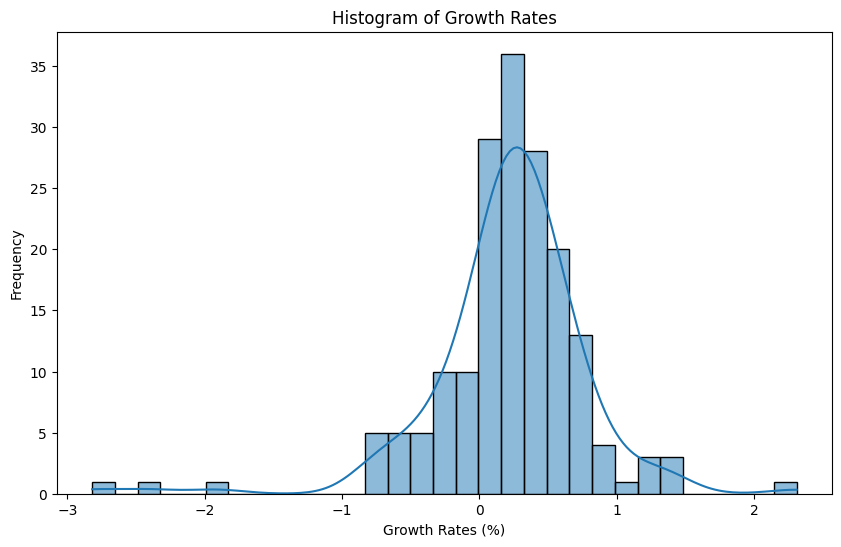

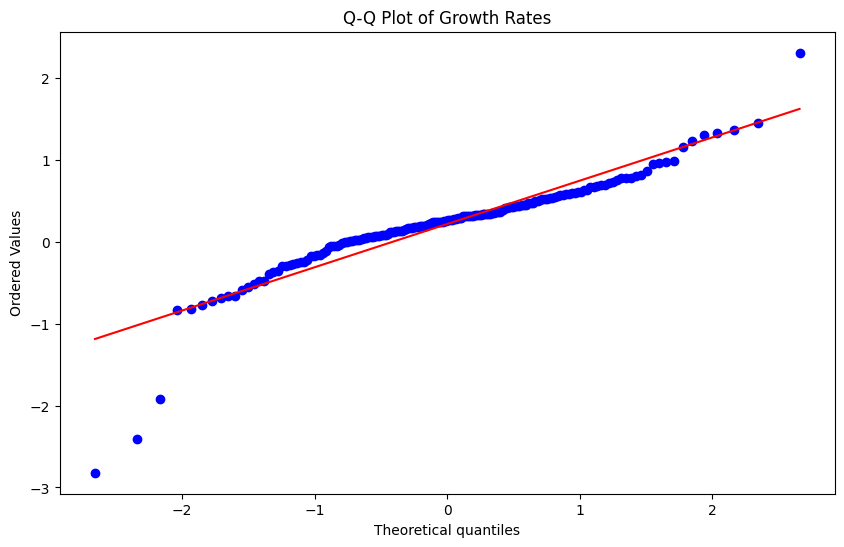

Kolmogorov-Smirnov Test (t-distribution): Statistic=0.15176776909976591, p-value=0.00052709865596091
Kolmogorov-Smirnov Test (normal distribution): Statistic=0.29172499890762155, p-value=9.200135147003716e-14
            Index              QUARTER      IMPORTS    IMPORTSSA        DREC  \
count  176.000000                  176   176.000000   176.000000  176.000000   
mean    87.500000  2001-11-15 10:30:00  1682.171409  1683.484028    0.113636   
min      0.000000  1980-01-01 00:00:00   284.556000   279.202000    0.000000   
25%     43.750000  1990-12-09 00:00:00   616.376000   625.492500    0.000000   
50%     87.500000  2001-11-16 00:00:00  1460.312000  1481.221000    0.000000   
75%    131.250000  2012-10-24 00:00:00  2740.266000  2750.920000    0.000000   
max    175.000000  2023-10-01 00:00:00  4105.524000  4069.839000    1.000000   
std     50.950957                  NaN  1098.856881  1098.013553    0.318275   

            month  laggedImports  laggedImportssa  IMPORTSSA_log  \
co

In [ ]:
#Histogram
plt.figure(figsize=(10, 6))
sns.histplot(inputregression['logIMPORTSSA_diff_%'], kde=True)
plt.title('Histogram of Growth Rates')
plt.xlabel('Growth Rates (%)')
plt.ylabel('Frequency')
plt.show()

#Q-Q Plot?
plt.figure(figsize=(10, 6))
stats.probplot(inputregression['logIMPORTSSA_diff_%'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Growth Rates')
plt.show()

# Perform Kolmogorov-Smirnov test for a t-distribution
degrees_of_freedom = 2  # Example degrees of freedom
mean = np.mean(inputregression['logIMPORTSSA_diff_%'])
std = np.std(inputregression['logIMPORTSSA_diff_%'])
ks_test_t = stats.kstest(inputregression['logIMPORTSSA_diff_%'], 't', args=(degrees_of_freedom, mean, std))

print(f'Kolmogorov-Smirnov Test (t-distribution): Statistic={ks_test_t.statistic}, p-value={ks_test_t.pvalue}')

# Perform Kolmogorov-Smirnov test for normal
ks_test = stats.kstest(inputregression['logIMPORTSSA_diff_%'], 'norm')
print(f'Kolmogorov-Smirnov Test (normal distribution): Statistic={ks_test.statistic}, p-value={ks_test.pvalue}')

#summary stats
print(inputregression.describe())
print(skew(inputregression['logIMPORTSSA_diff_%']))
print(kurtosis(inputregression['logIMPORTSSA_diff_%']))

# Perform Jarque-Bera test
jb_test_statistic, jb_p_value = stats.jarque_bera(inputregression['logIMPORTSSA_diff_%'])
print(f'Jarque Bera Test: Statistic = {jb_test_statistic}, pvalue = {jb_p_value}')

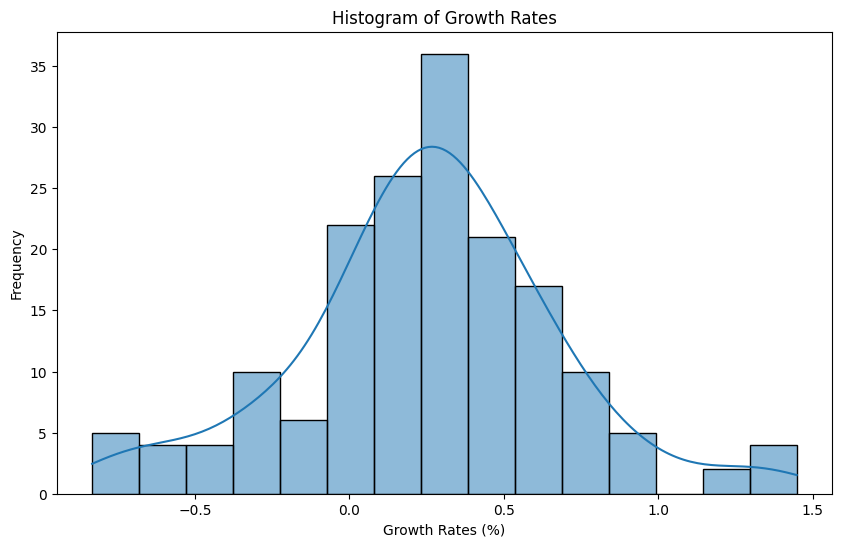

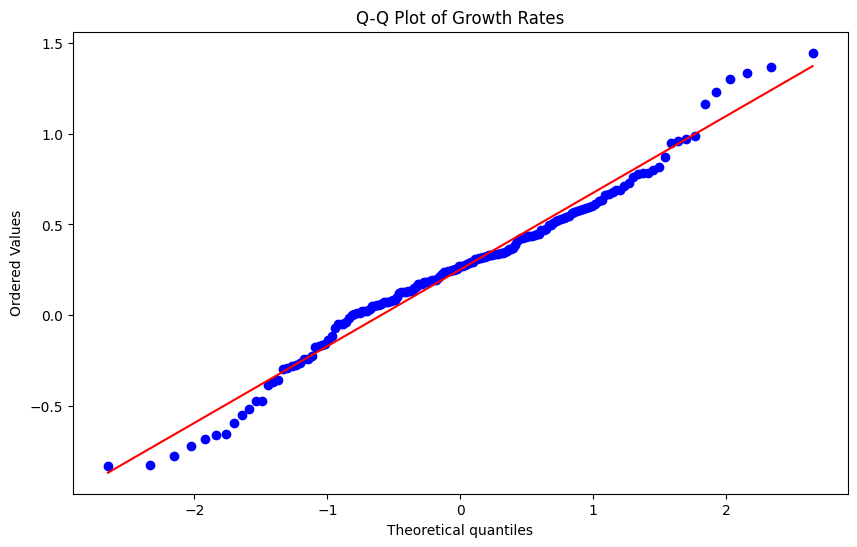

Kolmogorov-Smirnov Test (t-distribution): Statistic=0.1012827302164496, p-value=0.054645904170943616
Kolmogorov-Smirnov Test (normal distribution): Statistic=0.3048063942564587, p-value=1.1152860624798744e-14
            Index                        QUARTER      IMPORTS    IMPORTSSA  \
count  172.000000                            172   172.000000   172.000000   
mean    86.313953  2001-07-30 03:04:11.162790656  1666.775907  1667.946727   
min      0.000000            1980-01-01 00:00:00   284.556000   279.202000   
25%     42.750000            1990-09-08 00:00:00   615.918000   621.331000   
50%     85.500000            2001-05-16 12:00:00  1434.346000  1444.136500   
75%    130.250000            2012-07-24 00:00:00  2740.266000  2750.920000   
max    175.000000            2023-10-01 00:00:00  4105.524000  4069.839000   
std     50.814250                            NaN  1105.524975  1104.958925   

             DREC       month  laggedImports  laggedImportssa  IMPORTSSA_log  \
count  1

In [ ]:
filtered_df = inputregression[(inputregression['logIMPORTSSA_diff_%'] >= -1.5) & (inputregression['logIMPORTSSA_diff_%'] <= 2)]
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['logIMPORTSSA_diff_%'], kde=True)
plt.title('Histogram of Growth Rates')
plt.xlabel('Growth Rates (%)')
plt.ylabel('Frequency')
plt.show()

#Q-Q Plot?
plt.figure(figsize=(10, 6))
stats.probplot(filtered_df['logIMPORTSSA_diff_%'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Growth Rates')
plt.show()

# Perform Kolmogorov-Smirnov test for a t-distribution
degrees_of_freedom = 2  # Example degrees of freedom
mean = np.mean(filtered_df['logIMPORTSSA_diff_%'])
std = np.std(filtered_df['logIMPORTSSA_diff_%'])
ks_test_t = stats.kstest(filtered_df['logIMPORTSSA_diff_%'], 't', args=(degrees_of_freedom, mean, std))

print(f'Kolmogorov-Smirnov Test (t-distribution): Statistic={ks_test_t.statistic}, p-value={ks_test_t.pvalue}')

# Perform Kolmogorov-Smirnov test for normal
ks_test = stats.kstest(filtered_df['logIMPORTSSA_diff_%'], 'norm')
print(f'Kolmogorov-Smirnov Test (normal distribution): Statistic={ks_test.statistic}, p-value={ks_test.pvalue}')

#summary stats
print(filtered_df.describe())
print(skew(filtered_df['logIMPORTSSA_diff_%']))
print(kurtosis(filtered_df['logIMPORTSSA_diff_%']))

# Perform Jarque-Bera test
jb_test_statistic, jb_p_value = stats.jarque_bera(filtered_df['logIMPORTSSA_diff_%'])
print(f'Jarque Bera Test: Statistic = {jb_test_statistic}, pvalue = {jb_p_value}')

<Figure size 1200x600 with 0 Axes>

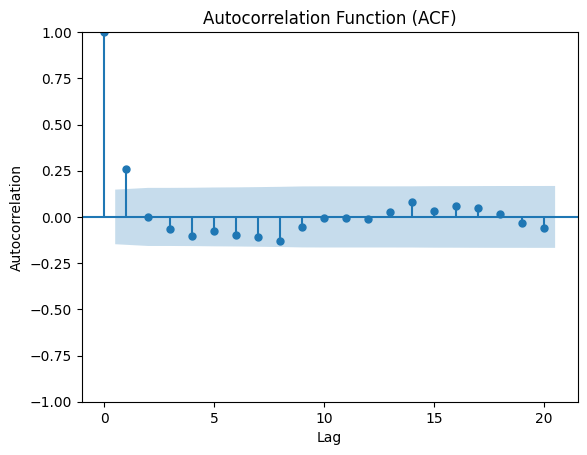

<Figure size 1200x600 with 0 Axes>

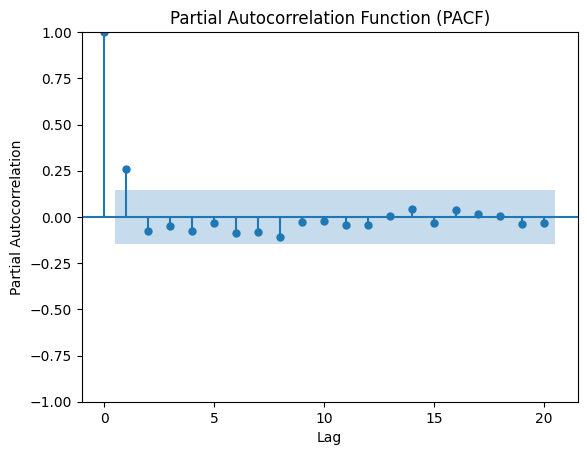

In [ ]:
# Plot ACF (Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_acf(inputregression['laggedIMPORTSSA_diff_%'], lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot ACF (Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_pacf(inputregression['laggedIMPORTSSA_diff_%'], lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

<Figure size 1200x600 with 0 Axes>

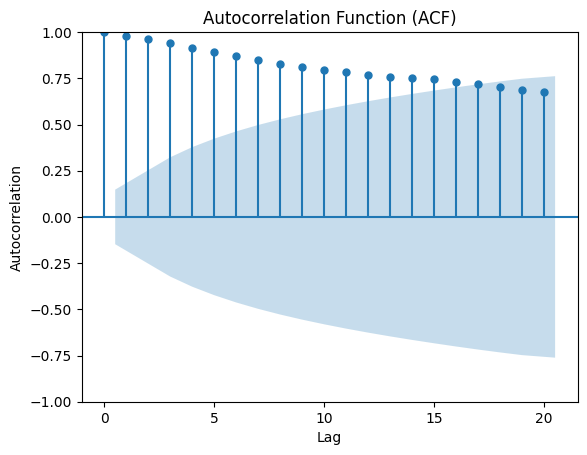

<Figure size 1200x600 with 0 Axes>

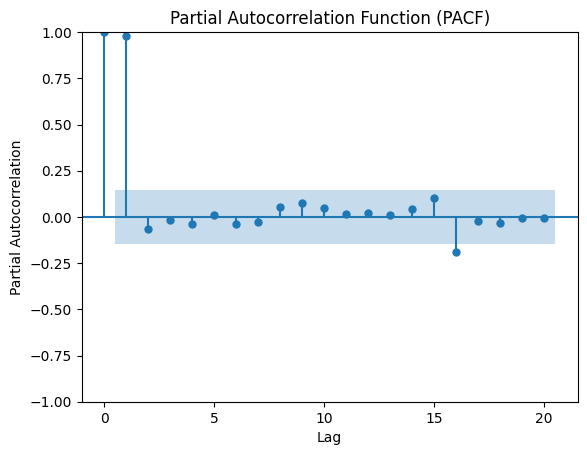

In [ ]:
# Plot ACF (Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_acf(newinputdata['IMPORTSSA'], lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot ACF (Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_pacf(newinputdata['IMPORTSSA'], lags=20, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()